---
# **Medición de carga y descarga de un capacitor, usando ESP32 y python**
---
Andrés Felipe Riaño Quintanilla     1083928808

Santiago Julio Dávila               1000413445

---
Laboratorio Avanzado I, Instituto de Física, Universidad de Antioquia

## **Introducción**

En el estudio de circuitos eléctricos, los sistemas conformados por resistencias y capacitores (circuitos **RC**) son fundamentales para comprender fenómenos transitorios, como la **carga y descarga de un condensador**. Estos procesos son comunes en múltiples aplicaciones electrónicas, desde filtros hasta temporizadores y fuentes de alimentación [1]. Comprender cómo varía el voltaje en un condensador en función del tiempo permite modelar con precisión estos comportamientos y ajustar sistemas de control y procesamiento de señales.

Un condensador, al conectarse a una fuente de voltaje a través de una resistencia, no se carga instantáneamente, sino que lo hace de manera exponencial. Este comportamiento está gobernado por la **constante de tiempo** del circuito, denotada como $\tau = RC$, donde $R$ es la resistencia y $C$ la capacitancia [2]. La expresión matemática que describe el voltaje en el condensador durante la **carga** es:

$$
V_c(t) = V_0 \left(1 - e^{-\frac{t}{RC}}\right)
$$

Dónde $V_0$ es el voltaje de la fuente, $R$ es el valor de la resistencia y $C$ es el valor de la capacitancia.

Mientras que durante la **descarga**, el voltaje sigue la función:

$$
V_d(t) = V_0 e^{-\frac{t}{RC}}
$$

En este experimento, utilizaremos un Arduino **ESP32** para realizar las mediciones del voltaje en el condensador durante los procesos de carga y descarga. Luego, procesaremos los datos utilizando **Python**, con el objetivo de realizar un **ajuste de curva exponencial** y así determinar experimentalmente la **constante de tiempo** del sistema $\tau = RC$. De esta manera, buscamos validar el modelo teórico a partir de datos experimentales y evaluar el grado de concordancia entre ambos.

## **Desarrollo Experimental**

Para el montaje experimental se requirieron los siguientes implementos:

- Capacitor de $1000 \mu F$
- Resistencia de $540 \Omega$
- Espduino-32 HW-707

Los elementos anteriores se ensamblan para formar el circuito representado en la Figura 1. 

<p>
  <img src="https://raw.githubusercontent.com/Andres-Ria/Documentos/refs/heads/main/Fig1.jpg" alt="Descripción" width="500" style="vertical-align: middle;">


  <span style="font-size:16px;"> **Figura 1:** esquema del circuito. La alimentación se realiza con el PIN 25 y la lectura con el PIN 2 [3], [4].</span>
</p>

Para la toma de datos, el circuito anterior fue controlado por la IDE de Arduino mediante el siguiente código:
```
// Definición de pines utilizados
const int salidaVoltaje = 25;  // DAC: genera el voltaje
const int entradaVoltaje = 2;  // ADC: mide el voltaje

unsigned long tiempoInicio;

void setup() {
  // Configurar comunicación por puerto serie
  Serial.begin(115200);

  // Establecer pin del DAC como salida
  pinMode(salidaVoltaje, OUTPUT);

  // Establecer pin del ADC como entrada
  pinMode(entradaVoltaje, INPUT);
}

void loop() {
  if (Serial.available() > 0) {
    int comando = Serial.read();

    if (comando == 'a') {
      digitalWrite(salidaVoltaje, HIGH);  // Activar carga inicial del capacitor
      delay(2000);  // Esperar 2 segundos

      tiempoInicio = millis();  // Guardar el tiempo de inicio

      // Ejecutar 5 ciclos de carga y descarga
      for (int ciclo = 0; ciclo < 10; ciclo++) {
        digitalWrite(salidaVoltaje, ciclo % 2);  // Alternar entre carga y descarga

        // En cada ciclo, registrar 200 lecturas de voltaje
        for (int muestra = 0; muestra < 200; muestra++) {
          int lecturaADC = analogRead(entradaVoltaje);  // Lectura del valor ADC

          float voltajeCalculado = (lecturaADC / 4095.0) * 3.3;  // Conversión a voltaje

          unsigned long tiempoTranscurrido = millis() - tiempoInicio;  // Tiempo desde el inicio

          // Enviar datos por puerto serie (tiempo;voltaje)
          Serial.print(tiempoTranscurrido);
          Serial.print(";");
          Serial.println(voltajeCalculado);

          delay(20);  // Pausa entre muestras
        }
      }
    }
  }
}
```
El capacitor se conectó a un pin DAC para controlar su estado y a un pin ADC para medir el voltaje. El programa alternó entre carga y descarga, tomando 200 mediciones en cada ciclo, registrando el tiempo en milisegundos y el voltaje en voltios. Estos datos se enviaron por el puerto serie en formato texto, separados por punto y coma.

Adicionalmente, se creó un programa en Python que facilitó la conexión con el ESP32, la recopilación de los datos enviados y su guardado en un archivo CSV. El código utilizado es el siguiente:

```python

# Librerías necesarias para el programa
import serial
import time
import csv

# Función para inicializar la conexión serial
def conectar_serial(puerto, velocidad):
    conexion = serial.Serial(port=puerto, baudrate=velocidad)
    time.sleep(2)  # Esperar un momento para asegurar conexión
    return conexion

# Función que guarda los datos en un archivo CSV
def guardar_datos(nombre_archivo, datos):
    with open(nombre_archivo, mode='w', newline='') as archivo:
        escritor = csv.writer(archivo)
        escritor.writerow(['Tiempo (ms)', 'Voltaje (V)'])  # Encabezados del archivo
        escritor.writerows(datos)

# Función principal que maneja la adquisición de datos
def recolectar_mediciones(conexion):
    registros = []
    try:
        while True:
            if conexion.in_waiting:
                contenido = conexion.readline().decode().strip()
                if ";" in contenido:
                    partes = contenido.split(";")
                    try:
                        tiempo_ms = float(partes[0])
                        voltios = float(partes[1])
                        print(f"Tiempo: {tiempo_ms} ms, Voltaje: {voltios} V")
                        registros.append([tiempo_ms, voltios])
                    except ValueError:
                        continue
    except KeyboardInterrupt:
        print("\nProceso interrumpido por el usuario.")
    finally:
        conexion.close()
        return registros

# --- Ejecución del programa ---
if __name__ == '__main__':
    puerto_serie = 'COM12'
    velocidad_baud = 115200
    archivo_salida = 'lecturas.csv'

    dispositivo = conectar_serial(puerto_serie, velocidad_baud)

    accion = input("Presiona la letra 'a' para comenzar la lectura: ").strip()
    if accion == 'a':
        dispositivo.write(accion.encode('utf-8'))
        datos_obtenidos = recolectar_mediciones(dispositivo)
        guardar_datos(archivo_salida, datos_obtenidos)
        print("\nDatos guardados exitosamente.")
    else:
        print("Entrada no válida. Fin del programa.")

```
El programa en Python se encarga de establecer una conexión serial con el ESP32, enviar un comando para iniciar la transmisión de datos, y recibir valores de tiempo y voltaje en tiempo real. Estos datos se muestran en consola para monitoreo y se almacenan en un archivo CSV con columnas de Tiempo (ms) y Voltaje (V). La ejecución continúa hasta que el usuario la detiene manualmente, momento en el cual se cierra la conexión y se guardan todos los datos recolectados.

## **Resultados**

A continuación se mostrarán los datos recolectados por el Arduino y su comunicación con Python.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit

In [2]:
# Lee el archivo de los datos
df = pd.read_csv('https://raw.githubusercontent.com/Andres-Ria/LabAv1/refs/heads/main/LabAv1-P2/datap2.csv')
df.iloc[34:44]

,Tiempo (ms),Voltaje (V)
34,11240.0,0.00
35,11280.0,0.00
36,11320.0,0.03
37,11360.0,0.11
38,11400.0,0.19
39,11440.0,0.29
40,11480.0,0.36
41,11520.0,0.44
42,11560.0,0.51
43,11600.0,0.58


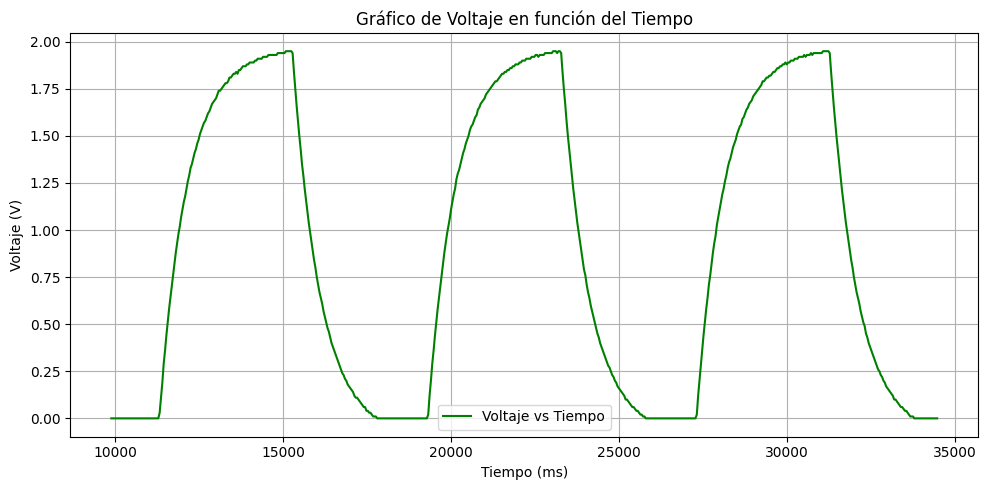

In [3]:
#Graficar los datos obtenidos experimentalmente
plt.figure(figsize=(10, 5))
plt.plot(df['Tiempo (ms)'], df['Voltaje (V)'], label='Voltaje vs Tiempo', color='green')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje (V)')
plt.title('Gráfico de Voltaje en función del Tiempo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Las tres curvas de carga y las tres curvas de descarga se promediaron respectivamente y a los valores resultantes se les hizo en análisis de errores correspondiente usando la librería `pandas`.

In [4]:
#En primera instancia se extrajeron los índices de donde empieza y termina cada proceso carga-descarga.

indices = df["Voltaje (V)"][df["Voltaje (V)"] != 0.0].index.tolist()

# Detectar los saltos
saltos = [indices[0]]  # Siempre incluir el primero

for i in range(1, len(indices)):
    if indices[i] - indices[i - 1] > 1:
        saltos.append(indices[i - 1])  # último del bloque anterior
        saltos.append(indices[i])      # primero del nuevo bloque

# Agregar el último valor si no es consecutivo al anterior
if indices[-1] != saltos[-1]:
    saltos.append(indices[-1])

# Ordenar y mostrar
saltos = sorted(saltos)
print("Saltos detectados en:", saltos)

Saltos detectados en: [36, 197, 236, 397, 436, 597]


In [5]:
#Estos son los dataframes correspondientes a cada uno de los tres procesos de carga y descarga:

Vcd_1 = df.loc[saltos[0]-1:saltos[1]+2]
Vcd_2 = df.loc[saltos[2]-1:saltos[3]+2]
Vcd_3 = df.loc[saltos[4]-1:saltos[5]+2]

#Estos son los índices que corresponden al valor de voltaje máximo para cada proceso de carga y descarga:

max_ind_Vcd_1 = Vcd_1["Voltaje (V)"][Vcd_1["Voltaje (V)"] == Vcd_1["Voltaje (V)"].max()].index.tolist()
max_ind_Vcd_2 = Vcd_2["Voltaje (V)"][Vcd_2["Voltaje (V)"] == Vcd_2["Voltaje (V)"].max()].index.tolist()
max_ind_Vcd_3 = Vcd_3["Voltaje (V)"][Vcd_3["Voltaje (V)"] == Vcd_3["Voltaje (V)"].max()].index.tolist()

#Estos son los dataframes correspondientes a cada proceso de carga y descarga por separado:

Vc_1 = Vcd_1.loc[:max_ind_Vcd_1[-1]]  #Primer proceso de carga
Vd_1 = Vcd_1.loc[max_ind_Vcd_1[-1]+1:]  #Primer proceso de descarga

Vc_2 = Vcd_2.loc[:max_ind_Vcd_2[-1]]  #Segundo proceso de carga
Vd_2 = Vcd_2.loc[max_ind_Vcd_2[-1]+1:]  #Segundo proceso de descarga

Vc_3 = Vcd_3.loc[:max_ind_Vcd_3[-1]]  #Tercer proceso de carga
Vd_3 = Vcd_3.loc[max_ind_Vcd_3[-1]+1:]  #Tercer proceso de descarga

#Dataframe con todos los voltajes de carga:

Vc = Vc_1.reset_index(drop=True)
Vc["Tiempo (ms)"] = Vc_1.reset_index(drop=True)["Tiempo (ms)"].apply(lambda x:x-11280.0)
Vc = Vc.rename(columns={"Voltaje (V)": "Vc_1 (V)"})
Vc["Vc_2 (V)"] = Vc_2["Voltaje (V)"].reset_index(drop=True)
Vc["Vc_3 (V)"] = Vc_3["Voltaje (V)"].reset_index(drop=True)

#Dataframe con todos los voltajes de descarga:

Vd = Vd_1.reset_index(drop=True)
Vd["Tiempo (ms)"] = Vd_1.reset_index(drop=True)["Tiempo (ms)"].apply(lambda x:x-15280.0)
Vd = Vd.rename(columns={"Voltaje (V)": "Vd_1 (V)"})
Vd["Vd_2 (V)"] = Vd_2["Voltaje (V)"].reset_index(drop=True)
Vd["Vd_3 (V)"] = Vd_3["Voltaje (V)"].reset_index(drop=True)
Vd = Vd.iloc[:-1]

#Promedios
Vc["Vc_prom (V)"] = Vc.apply(lambda x: np.mean([x['Vc_1 (V)'],x['Vc_2 (V)'],x['Vc_3 (V)']]), axis=1)
Vd["Vd_prom (V)"] = Vd.apply(lambda x: np.mean([x['Vd_1 (V)'],x['Vd_2 (V)'],x['Vd_3 (V)']]), axis=1)

#Error estadístico
Vc["ErrEst_Vc (V)"] = Vc.apply(lambda x: np.std([x['Vc_1 (V)'],x['Vc_2 (V)'],x['Vc_3 (V)']]), axis=1)
Vd["ErrEst_Vd (V)"] = Vd.apply(lambda x: np.std([x['Vd_1 (V)'],x['Vd_2 (V)'],x['Vd_3 (V)']]), axis=1)

#Error experimental
Vc['ErrExp_Vc (V)'] = np.full(len(Vc['Vc_1 (V)']),3./4095)
Vd['ErrExp_Vd (V)'] = np.full(len(Vd['Vd_1 (V)']),3./4095)

#Error dominante
Vc['ErrDom_Vc (V)'] = Vc.apply(lambda x: np.max([x['ErrEst_Vc (V)'],x['ErrExp_Vc (V)']]), axis=1)
Vd['ErrDom_Vd (V)'] = Vd.apply(lambda x: np.max([x['ErrEst_Vd (V)'],x['ErrExp_Vd (V)']]), axis=1)

In [6]:
#Dataframe completo de carga:

Vc

,Tiempo (ms),Vc_1 (V),Vc_2 (V),Vc_3 (V),Vc_prom (V),ErrEst_Vc (V),ErrExp_Vc (V),ErrDom_Vc (V)
0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000733,0.000733
1,40.0,0.03,0.02,0.02,0.023333,0.004714,0.000733,0.004714
2,80.0,0.11,0.12,0.12,0.116667,0.004714,0.000733,0.004714
3,120.0,0.19,0.20,0.20,0.196667,0.004714,0.000733,0.004714
4,160.0,0.29,0.29,0.28,0.286667,0.004714,0.000733,0.004714
...,...,...,...,...,...,...,...,...
95,3800.0,1.95,1.95,1.95,1.950000,0.000000,0.000733,0.000733
96,3840.0,1.95,1.95,1.95,1.950000,0.000000,0.000733,0.000733
97,3880.0,1.95,1.94,1.95,1.946667,0.004714,0.000733,0.004714
98,3920.0,1.95,1.95,1.95,1.950000,0.000000,0.000733,0.000733


In [7]:
#Dataframe completo de descarga:

Vd

,Tiempo (ms),Vd_1 (V),Vd_2 (V),Vd_3 (V),Vd_prom (V),ErrEst_Vd (V),ErrExp_Vd (V),ErrDom_Vd (V)
0,0.0,1.94,1.94,1.94,1.940000,2.220446e-16,0.000733,0.000733
1,40.0,1.84,1.84,1.84,1.840000,0.000000e+00,0.000733,0.000733
2,80.0,1.75,1.75,1.75,1.750000,0.000000e+00,0.000733,0.000733
3,120.0,1.66,1.67,1.66,1.663333,4.714045e-03,0.000733,0.004714
4,160.0,1.58,1.58,1.58,1.580000,0.000000e+00,0.000733,0.000733
...,...,...,...,...,...,...,...,...
59,2360.0,0.02,0.02,0.02,0.020000,0.000000e+00,0.000733,0.000733
60,2400.0,0.01,0.02,0.01,0.013333,4.714045e-03,0.000733,0.004714
61,2440.0,0.01,0.01,0.01,0.010000,0.000000e+00,0.000733,0.000733
62,2480.0,0.01,0.01,0.01,0.010000,0.000000e+00,0.000733,0.000733


Con los voltajes de carga y descarga promediados, se realizó un ajuste y con él, se encontró la constante de tiempo del circuito **$\tau$**.

**Carga del capacitor:**

In [8]:
#Función para realizar el ajuste:

def carga_capacitor(t, V0, RC):
    """
    Modelo de carga de un capacitor en un circuito RC.

    Esta función describe el voltaje en los terminales de un capacitor 
    en función del tiempo durante su proceso de carga, según la ecuación:

        V_c(t) = V0 * (1 - exp(-t / RC))

    donde:
        - V0 es el voltaje final al que tiende el capacitor.
        - R*C es la constante de tiempo del circuito.
        - t es el tiempo transcurrido desde el inicio de la carga.

    Parámetros:
    ------------
    t : float o array_like
        Tiempo(s) transcurrido(s) desde el inicio de la carga.
    V0 : float
        Voltaje final (máximo) al que se carga el capacitor.
    RC : float
        Constante de tiempo del circuito (producto de resistencia por capacitancia).

    Retorna:
    --------
    Vc : float o ndarray
        Voltaje en el capacitor para el/los instante(s) de tiempo t.
    """
    return V0 * (1 - np.exp(-t / RC))

# Ajuste
popt, pcov = curve_fit(carga_capacitor, Vc["Tiempo (ms)"], Vc["Vc_prom (V)"], p0=[1.95, 390])

# Parámetros ajustados
V0_fit, RC_fit = popt

# Errores (desviaciones estándar) de los parámetros
V0_err, RC_err = np.sqrt(np.diag(pcov))

# Imprimir resultados con "±"
print(f"V0 ajustado: ({V0_fit:.3f} ± {V0_err:.3f}) V")
print(f"RC ajustado: ({RC_fit:.3f} ± {RC_err:.3f}) ms")

V0 ajustado: (1.977 ± 0.003) V
RC ajustado: (877.095 ± 4.608) ms


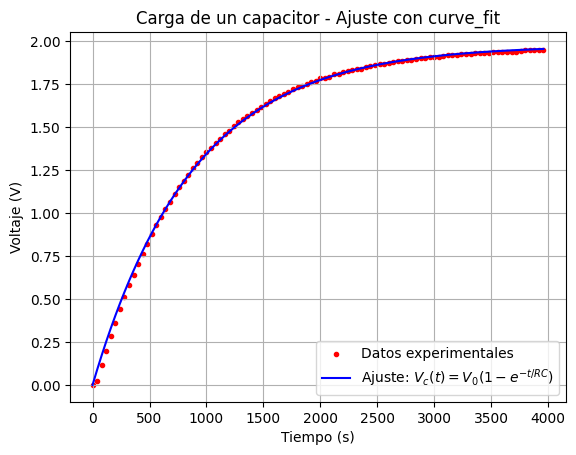

In [9]:
# Generar valores suaves para la curva ajustada
t_fit = np.linspace(Vc["Tiempo (ms)"].min(), Vc["Tiempo (ms)"].max(), 100)
V_fit = carga_capacitor(t_fit, *popt)

plt.scatter(Vc["Tiempo (ms)"], Vc["Vc_prom (V)"], label="Datos experimentales", color="red",marker='.')


plt.plot(t_fit, V_fit, label="Ajuste: $V_c(t) = V_0 (1 - e^{-t/RC})$", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Carga de un capacitor - Ajuste con curve_fit")
plt.legend()
plt.grid(True)
plt.show()

**Descarga del capacitor:**

In [10]:
#Función para realizar el ajuste:

def descarga_capacitor(t, V0, RC):
    """
    Modelo de descarga de un capacitor en un circuito RC.

    Esta función describe el voltaje en los terminales de un capacitor 
    en función del tiempo durante su proceso de descarga, según la ecuación:

        V_d(t) = V0 * exp(-t / RC)

    donde:
        - V0 es el voltaje inicial del capacitor.
        - R*C es la constante de tiempo del circuito.
        - t es el tiempo transcurrido desde el inicio de la descarga.

    Parámetros:
    ------------
    t : float o array_like
        Tiempo(s) transcurrido(s) desde el inicio de la descarga.
    V0 : float
        Voltaje inicial del capacitor.
    RC : float
        Constante de tiempo del circuito (producto de resistencia por capacitancia).

    Retorna:
    --------
    Vd : float o ndarray
        Voltaje en el capacitor para el/los instante(s) de tiempo t.
    """
    return V0 * np.exp(-t / RC)

from scipy.optimize import curve_fit
import numpy as np

# Supongamos que t y V son tus datos de tiempo y voltaje durante la descarga

# Ajuste
popt, pcov = curve_fit(descarga_capacitor, Vd["Tiempo (ms)"], Vd["Vd_prom (V)"], p0=[1.95, 800])  # p0 son valores iniciales estimados

# Parámetros ajustados
V0_fit, RC_fit = popt

# Errores
V0_err, RC_err = np.sqrt(np.diag(pcov))

# Imprimir con "±"
print(f"V0 ajustado: ({V0_fit:.3f} ± {V0_err:.3f}) V")
print(f"RC ajustado: ({RC_fit:.3f} ± {RC_err:.3f}) ms")

V0 ajustado: (1.986 ± 0.013) V
RC ajustado: (719.465 ± 7.015) ms


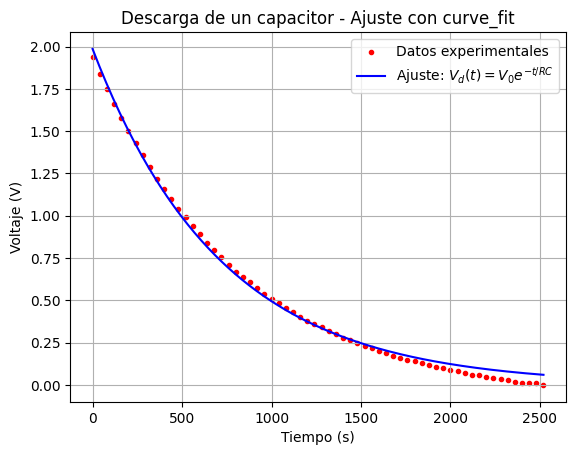

In [11]:
t_fit = np.linspace(Vd["Tiempo (ms)"].min(), Vd["Tiempo (ms)"].max(), 200)
V_fit = descarga_capacitor(t_fit, *popt)

plt.scatter(Vd["Tiempo (ms)"], Vd["Vd_prom (V)"], color="red", label="Datos experimentales", marker='.')
plt.plot(t_fit, V_fit, color="blue", label="Ajuste: $V_d(t) = V_0 e^{-t/RC}$")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.title("Descarga de un capacitor - Ajuste con curve_fit")
plt.legend()
plt.grid(True)
plt.show()

## **Conclusiones**

* Observando el comportamiento de las gráficas, se puede concluir que los datos recolectados de carga y descarga se ajustan razonablemente a las dos curvas de ajuste. Esto implica que en el proceso de carga, el voltaje creciente jamás alcanza completamente el valor suministrado por la fuente $V_0$, como era de esperarse.

* La constante de tiempo $\tau = RC$ en el proceso de carga dio $\tau=(877.095 ± 4.608) ms$. Esto quiere decir que después de $(877.095 ± 4.608) ms$, el voltaje en el capacitor alcanza alrededor del $63%$ de su valor final.

* Por otro lado, la constante de tiempo en el proceso de descarga dio $(719.465 ± 7.015) ms$. Lo cual quiere decir que el voltaje disminuye exponencialmente y alcanza un $37%$ de su valor inicial después de $(719.465 ± 7.015) ms$.

* El valor de voltaje inicial $V_0$ en los procesos de carga y descarga dio prácticamente igual; sin embargo, hubo discrepancias en los valores de $\tau$ de carga y descarga. Esto puede deberse en menor medida a errores estadísticos asociados a la dispersión de los datos y en mayor medida a que se están tomando tiempos muy pequeños y esto maximiza la incidencia de la resolución del equipo. 

## **Referencias**

[1] Sedra, A. S., & Smith, K. C. (2015). *Microelectronic Circuits* (7th ed.). Oxford University Press.

[2] Alexander, C. K., & Sadiku, M. N. O. (2017). *Fundamentals of Electric Circuits* (6th ed.). McGraw-Hill Education.

[3] Wokwi. (2025). Simulador de Arduino Wokwi. Recuperado el 11 de marzo de 2025, de https://wokwi.com

[4] Autodesk Inc. (2025). Tinkercad: diseño 3D, electrónica y programación en línea. Recuperado el 11 de marzo de 2025, de https://www.tinkercad.com

[5] Perdigão, R. (n.d.). ESP32 ADC – Lectura analógica con Arduino IDE. Random Nerd Tutorials. https://randomnerdtutorials.com/esp32-adc-analog-read-arduino-ide/

[6] Wikipedia. (2024, 5 de marzo). Propagación de errores. Wikipedia. https://es.wikipedia.org/wiki/Propagación_de_errores